# 2. Download and Unzip the Dataset

In [1]:
! pip install kaggle

In [2]:
! kaggle datasets download awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99%|██████████████████████████████████████▋| 4.13G/4.16G [00:17<00:00, 307MB/s]
100%|███████████████████████████████████████| 4.16G/4.16G [00:17<00:00, 257MB/s]


In [3]:
! unzip brats20-dataset-training-validation.zip "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_0[0-5][0-9]/*"


Archive:  brats20-dataset-training-validation.zip
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.nii  
  in

# 3. Dataset Information

The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:
1. **Native (T1)**
2. **Post-contrast T1-weighted (T1ce - contrast enhanced)**
3. **T2-weighted (T2)**
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)**

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
  1. **Label 0**: Not Tumor (NT) volume
  2. **Label 1**: Necrotic and non-enhancing tumor core (NCR/NET)
  3. **Label 2**: Peritumoral edema (ED)
  4. **Label 3**: Missing (No pixels in all the volumes contain label 3)
  5. **Label 4**: GD-enhancing tumor (ET)

As there are no pixels with the label 3, we will be replacing label 3 with label 4 so that there is continuity between the labels.

Now that we have downloaded the dataset, let's try to explore & understand it!

Inside the `brats20-dataset-training-validation` folder, you will find two datasets: one for Training and one for Validation. If you open the `BraTS2020_TrainingData` folder, you will notice that it contains another folder, that contains 369 samples (which are patients here). 

# 4. Load and Explore the Dataset

In [4]:
import os
import cv2
import glob
import time
import random
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [5]:
TRAIN_DATASET_PATH = "/kaggle/working/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [6]:
# load .nii file as a numpy array

test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_025/BraTS20_Training_025_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [7]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  711.0


As we can see the maximum pixel value of the image is `1854.6` which gives us a good idea to rescale these values. Rescaling pixel values is essential because it standardizes the intensity values across multimodal MRI scans (T1, T1ce, T2, FLAIR) to a uniform scale. This uniformity is crucial for consistent model training and analysis, as it ensures that variations in pixel intensity due to different imaging modalities and equipment do not bias the segmentation model. It facilitates the model's ability to learn meaningful features from the data for accurate tumor segmentation, regardless of the inherent differences in the raw MRI scans.

In [8]:
scaler = MinMaxScaler()

In [9]:
# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [10]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [11]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_035/BraTS20_Training_035_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_035/BraTS20_Training_035_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_035/BraTS20_Training_035_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_035/BraTS20_Training_035_seg.nii').get_fdata()

Slice Number: 45


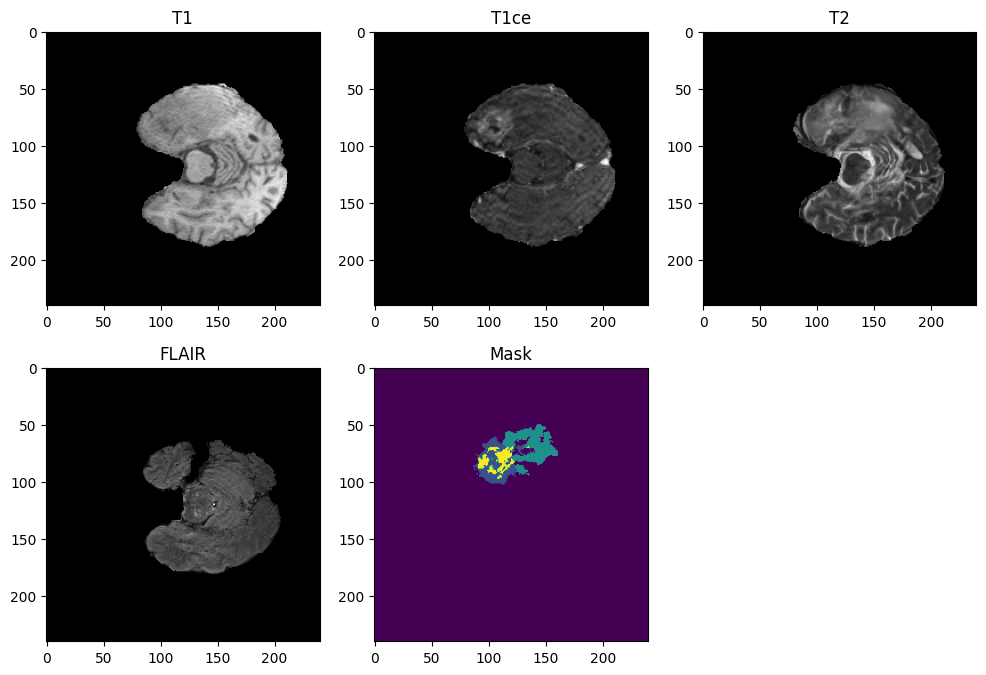

In [12]:
slice = 45

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

The four imaging modalities provide distinct perspectives on the same brain image, each highlighting different features.

**Detailed Description of Each Modality:**

1. **Native (T1):** This modality reveals the structure and composition of various tissue types in the brain. It's instrumental in identifying tumors, cysts, and other abnormalities.
2. **Post-contrast T1-weighted (T1ce, also known as T1Gd):** Similar to T1 images, but enhanced with a contrast agent (Gadolinium), which improves the visibility of abnormalities.
3. **T2-weighted (T2):** This modality highlights the fluid content within brain tissues.
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery):** This technique suppresses the fluid signals, making it easier to identify lesions that may not be visible on T1 or T2 images. It is particularly useful for detecting lesions in the brain's white matter, which are challenging to spot with other scans.

For medical experts, these four modalities collectively provide a comprehensive view, aiding in precise tumor analysis and confirmation. However, in our artificial intelligence approach, we aim to streamline the process by reducing computational and memory demands. Utilizing only two modalities can achieve this, making the segmentation task faster and more efficient.

To optimize our model, we will exclude the T1 modality since its enhanced counterpart, **T1ce**, provides better clarity. Similarly, we will omit the T2 modality because the fluids it highlights could negatively impact our predictions. Instead, the **T2-FLAIR** modality, which effectively highlights affected regions by suppressing fluid signals, will be more beneficial for our training.

### Images Format

You may have noticed that these images are in the .nii format. These scans are NIfTI files (Neuroimaging Informatics Technology Initiative). A NIfTI image provides a digital representation of a 3D object, such as a brain in our case. The NIfTI format is widely used in neuroimaging because it efficiently handles complex, multi-dimensional data and includes metadata for spatial orientation and scaling.

To gain a better understanding of the data structure, let's examine the shape of a modality scan and a segmentation mask. Note that in this dataset, all modalities and their corresponding segmentation masks share the same dimensions:

In [13]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


As we can see, the modalities and segmentations have 3 dimensions. Each dimension consists of a series of two-dimensional images, known as slices, which all contain the same number of pixels and are stacked together to create this 3D representation. For instance, in our previous example, we displayed the 95th slice of a certain dimension.

These 3 dimensions correspond to the three spatial dimensions of the image: width, height, and depth. In medical imaging, these dimensions are referred to as the axial (transverse), coronal, and sagittal planes, corresponding to the three main orientations of the human body and, therefore, the human brain.

Here is a quick presentation of these 3 planes:

1. **Axial (Transverse) Plane:** This plane divides the body into upper and lower parts and is perpendicular to the long axis of the body. In brain imaging, an axial slice is a horizontal cut through the brain.
2. **Coronal (Frontal) Plane:** This plane divides the body into front (anterior) and back (posterior) parts. A coronal slice in brain imaging is a vertical cut from one side of the head to the other, dividing the brain into front and back sections.
3. **Sagittal (Lateral) Plane:** This plane divides the body into left and right parts. A sagittal slice in brain imaging is a vertical cut from front to back, dividing the brain into left and right sections.

Understanding these planes is crucial for accurately interpreting medical images and effectively utilizing them in segmentation tasks. Each plane provides a different perspective, helping to localize and identify anatomical structures and abnormalities.

Slice number: 65


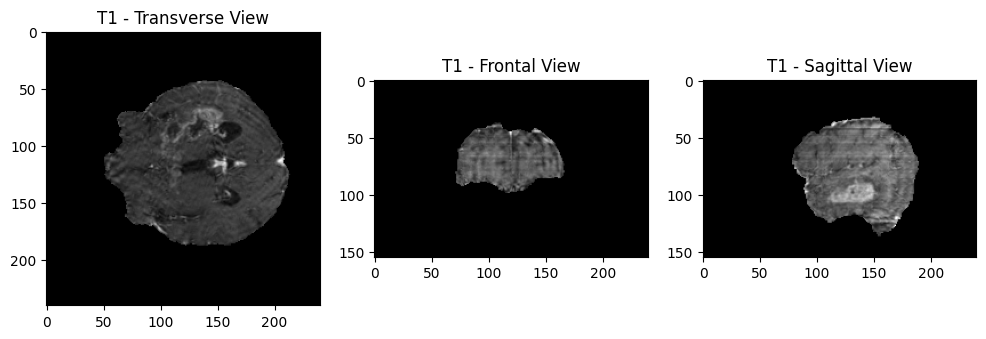

In [14]:
slice = 65

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

This visualization helps illustrate how each plane cuts through the brain and highlights different anatomical features, aiding in comprehensive analysis and segmentation.

---
Now that we understand the three dimensions, let's explore why we chose to display a specific slice, setting the slice number to 95. By examining all the slices, we can identify the slice that best represents the region of interest, such as the area where a tumor is located.

To visualize this, we will display all the slices along one dimension:

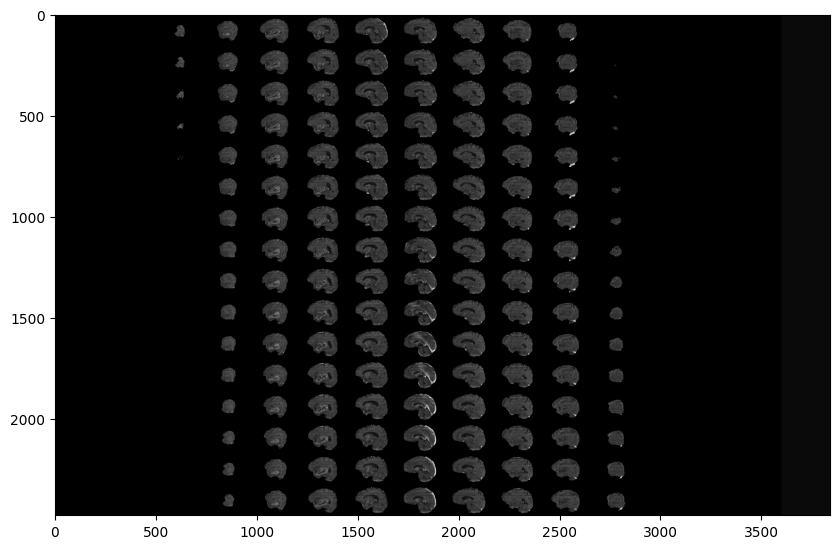

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray')

As you can see, two black parts are present on each side of our montage. These black parts correspond to the first and last slices of the plane. This indicates that a large portion of the slices does not contain much information, which is expected as the slices progressively represent the brain from one end to the other.

This observation is consistent across all modalities, planes, and even the expert-segmented images. The experts were unable to segment the slices that lack significant information, as these slices mostly capture areas outside the brain or the outermost regions that do not contain relevant anatomical details.

To further illustrate this, let's visualize a range of slices:

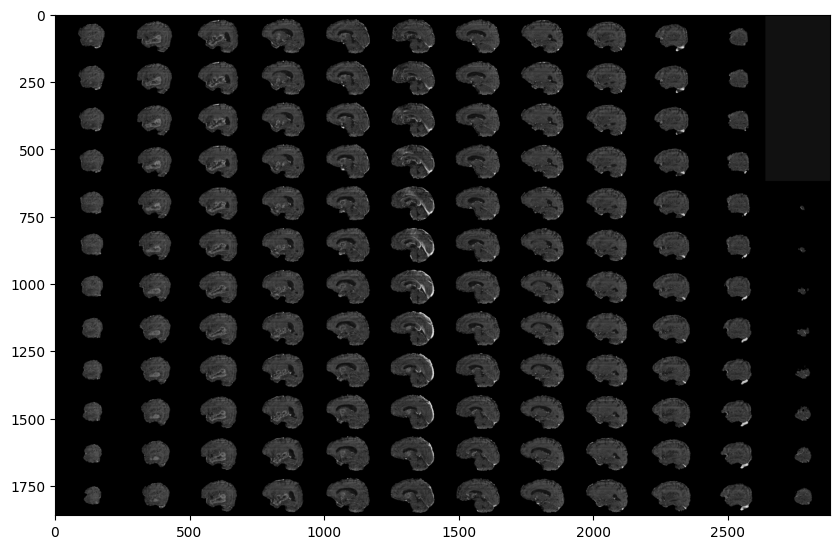

In [16]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray')

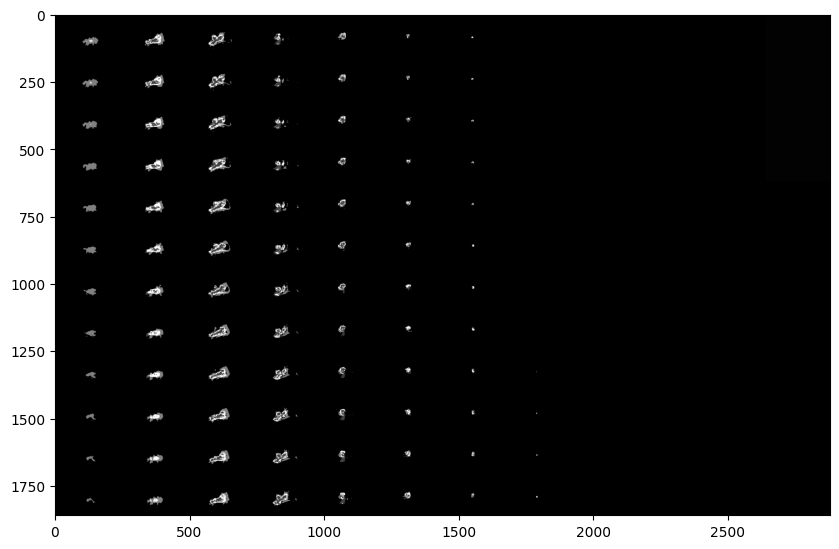

In [17]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray')

By focusing on a range of slices that contain meaningful content, we can better understand the anatomical structures and the regions where abnormalities, such as tumors, may be present. This approach helps in identifying the slices that are most relevant for analysis and segmentation.

This analysis applies to all other modalities and planes as well. The segmented images by experts also reflect this pattern, as they concentrate on the slices containing significant information. Slices that do not capture much of the brain's anatomy are often left unsegmented, as they provide little to no valuable data for diagnosis or analysis.

Now, let's focus on the segmentations provided by the experts. These segmentations provide critical information about the tumor:

1. **Location:** Identifies the exact location of the tumor in the brain.
2. **Size and Shape:** Measures the tumor's dimensions and form.
3. **Type:** Helps differentiate between various tumor types.
4. **Heterogeneity:** Reveals different components within the tumor (e.g., solid tissue, necrotic areas).
5. **Surrounding Tissue Involvement:** Shows how the tumor interacts with adjacent brain structures.
6. **Cross-Modality Comparison:** Provides a comprehensive view by comparing different imaging modalities.

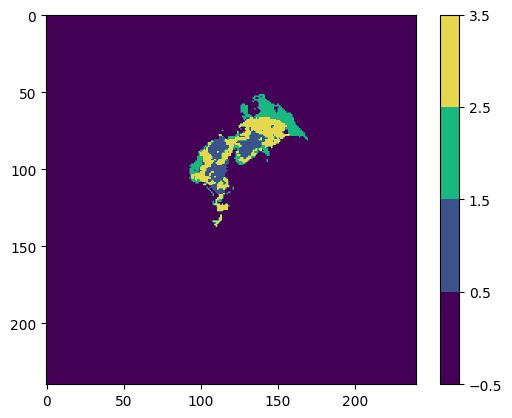

In [18]:
import matplotlib
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,65], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

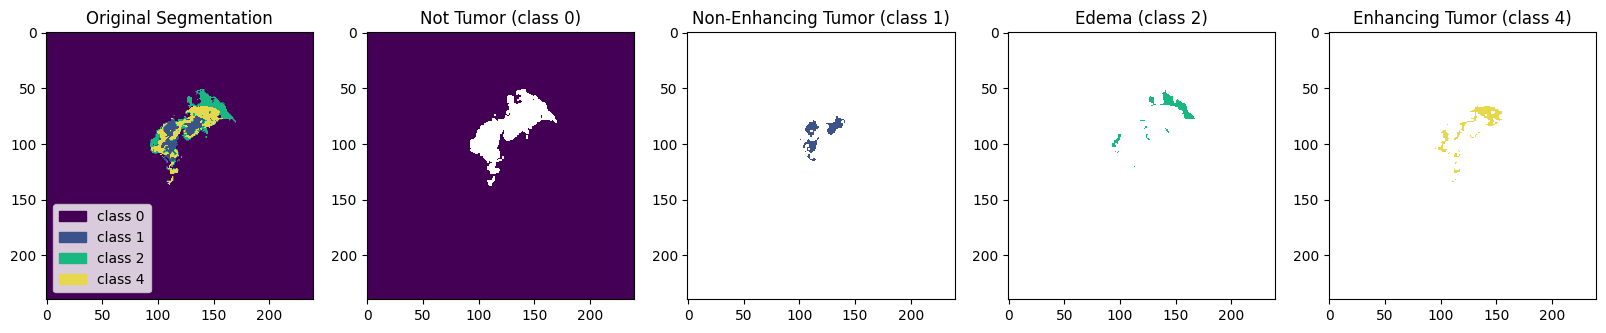

In [19]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

These insights are essential for accurate diagnosis, treatment planning, and monitoring. The segmentations help visualize the tumor clearly, making it easier to understand its characteristics and interactions with surrounding tissues.

---

To summarize our data exploration:

- **Modalities:** Each sample/patient has 4 different modalities (T1, T1CE, T2, and FLAIR), accompanied by a segmentation indicating tumor areas.
- **Selected Modalities:** We will focus on T1CE and FLAIR as they provide complementary information about the brain's anatomy and tissue contrast.
- **3D Images:** Each image is 3D and can be analyzed through 3 different planes composed of 2D slices.
- **Informative Slices:** Many slices contain little or no information. We will use slices in the (50:-50) interval. You can customize this range, but note that changing it may affect training time.
- **Segmentation Classes:** Segmentation images contain 1 to 4 classes. Class 4 will be reassigned to 3 since class 3 is missing.
- **Background Class:** Class 0 (background) is over-represented. Cropping might remove important information, so we will keep the images as they are.

Now that we understand our data better, it's time to prepare for model training.

# 5. Split the Dataset

To train and evaluate our model effectively, we need to split our dataset into three parts: the training set (70-80%) for training the model, the validation set (10-15%) for tuning hyperparameters and preventing overfitting, and the test set (10-15%) for evaluating the final model's performance. We can use random splitting to divide the data or stratified splitting to maintain the same class distribution across sets, which is particularly useful for imbalanced datasets. Properly splitting the dataset ensures that our model is robust and performs well on unseen data.

In [20]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [21]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 39
Validation length: 12
Test length: 8


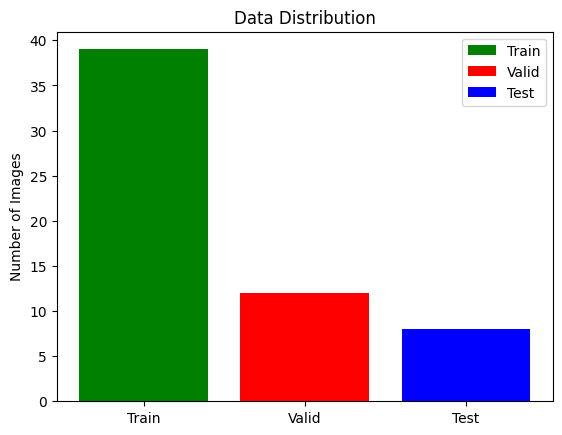

In [22]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

# 6. DataGenerator


To train a neural network for image segmentation, we need both raw image data (X) and ground truth segmentations (y). This allows the network to learn tumor patterns and make accurate predictions from patient scans. However, directly loading all 3D images can overload system memory and cause shape mismatch errors. Therefore, we use a Data Generator for image preprocessing, which includes several steps:

1. **Retrieve paths:** Obtain the paths for the T1CE and FLAIR modalities (for complementary anatomical and tissue contrast information) and the ground truth segmentation.
2. **Load data:** Load the selected slices (60-135) from these modalities and the corresponding segmentation.
3. **Create arrays:** Form X arrays with the slices from T1CE and FLAIR, and y arrays with the segmentation slices.
4. **Class reassignment:** Assign a value of 3 to all instances of 4 in the mask array to correct the missing class issue.

Additional preprocessing steps include:

- **Axial plane:** Use the axial plane for its square shape (240x240). This enables visualizing predictions across all planes without impact.
- **One-Hot Encoding:** Apply One-Hot Encoding to the y array to convert classes (0 to 3) into a numerical format suitable for neural networks, avoiding any implied hierarchy between classes. Here is what it consists of, for one slice:
   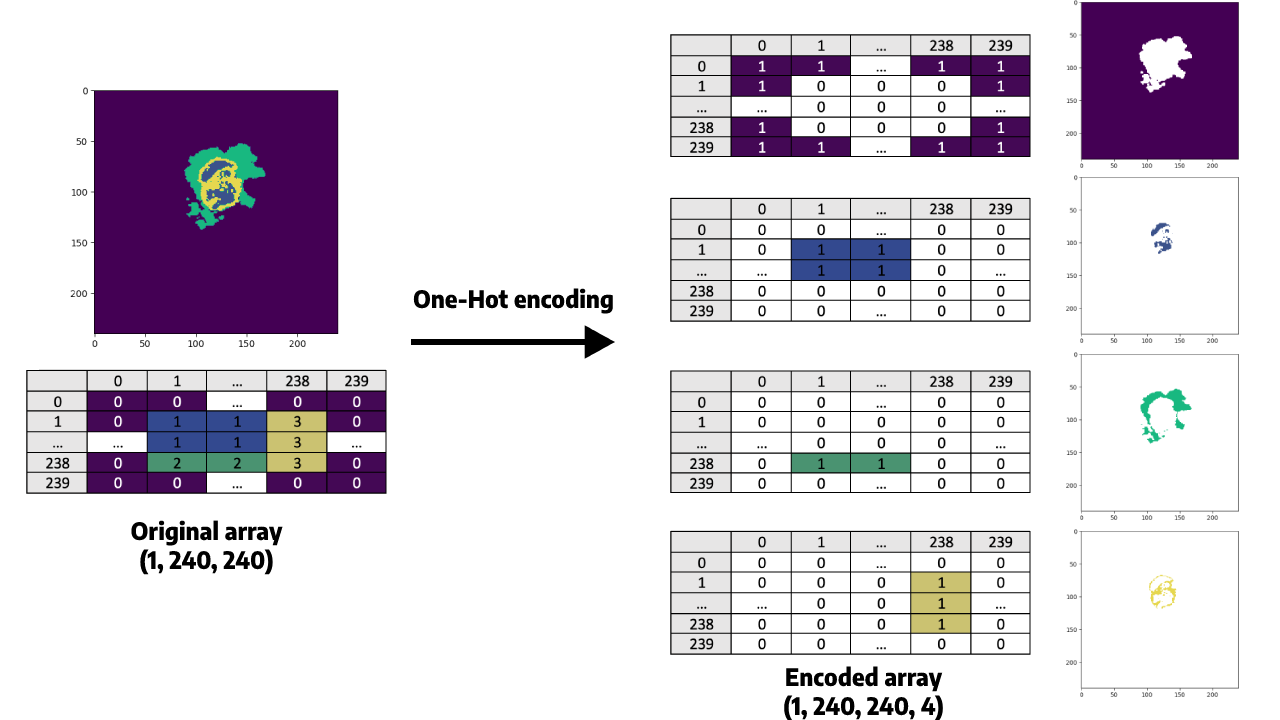
<br>
- **Resize images:** Resize each slice from (240x240) to (128x128). This shape is chosen because it is a power of two, fitting well with pooling layers (MaxPooling2D) in CNNs, and balances computational efficiency and information preservation.

While resizing to (256x256) could retain more detail, it significantly increases training time and memory usage. We can choose to train with (256x256) images, but we’ll need to adjust your U-Net architecture accordingly.

Now that we have a clear understanding of our data and preprocessing steps, we can proceed to prepare our model for training.

In [23]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [24]:
TRAIN_DATASET_PATH = "/kaggle/working/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

class BrainDataset(Dataset):
    'Generates data for PyTorch'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        # Create expanded list of samples (each ID gets VOLUME_SLICES samples)
        self.samples = []
        for ID in list_IDs:
            for slice_idx in range(VOLUME_SLICES):
                self.samples.append((ID, slice_idx))
        
        if self.shuffle:
            np.random.shuffle(self.samples)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.samples)

    def __getitem__(self, idx):
        'Generate one sample of data'
        case_id, slice_idx = self.samples[idx]
        
        # Generate data
        X, y = self._load_sample(case_id, slice_idx)
        
        return X, y
    
    def _load_sample(self, case_id, slice_idx):
        'Loads and processes one sample'
        case_path = os.path.join(TRAIN_DATASET_PATH, case_id)

        # Load FLAIR
        data_path = os.path.join(case_path, f'{case_id}_flair.nii')
        flair = nib.load(data_path).get_fdata()

        # Load T1CE
        data_path = os.path.join(case_path, f'{case_id}_t1ce.nii')
        t1ce = nib.load(data_path).get_fdata()

        # Load segmentation
        data_path = os.path.join(case_path, f'{case_id}_seg.nii')
        seg = nib.load(data_path).get_fdata()

        # Extract and resize the specific slice
        slice_pos = slice_idx + VOLUME_START_AT
        
        # Prepare input channels
        X = np.zeros((*self.dim, self.n_channels))
        X[:, :, 0] = cv2.resize(flair[:, :, slice_pos], self.dim)
        X[:, :, 1] = cv2.resize(t1ce[:, :, slice_pos], self.dim)
        
        # Prepare segmentation mask
        y_slice = seg[:, :, slice_pos]
        
        # Convert class 4 to class 3
        y_slice[y_slice == 4] = 3
        
        # Create one-hot encoding and resize
        y_one_hot = np.eye(4)[y_slice.astype(int)]  # Shape: (240, 240, 4)
        
        # Resize the one-hot mask
        y_resized = np.zeros((*self.dim, 4))
        for c in range(4):
            y_resized[:, :, c] = cv2.resize(y_one_hot[:, :, c], self.dim)
        
        # Normalize X
        X_max = np.max(X)
        if X_max > 0:
            X = X / X_max
        
        # Convert to PyTorch tensors and change dimension order to (C, H, W)
        X = torch.FloatTensor(X).permute(2, 0, 1)  # (2, IMG_SIZE, IMG_SIZE)
        y = torch.FloatTensor(y_resized).permute(2, 0, 1)  # (4, IMG_SIZE, IMG_SIZE)
        
        return X, y

# Alternative version that maintains batch-like structure similar to original
class BrainDatasetBatched(Dataset):
    'Generates data for PyTorch with batch-like structure'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        if self.shuffle:
            np.random.shuffle(self.list_IDs)

    def __len__(self):
        'Denotes the number of cases'
        return len(self.list_IDs)

    def __getitem__(self, idx):
        'Generate all slices for one case'
        case_id = self.list_IDs[idx]
        
        # Generate data for all slices of this case
        X, y = self._load_case(case_id)
        
        return X, y
    
    def _load_case(self, case_id):
        'Loads and processes all slices for one case'
        case_path = os.path.join(TRAIN_DATASET_PATH, case_id)

        # Load data
        flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
        t1ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
        seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()

        # Initialize arrays for all slices
        X = np.zeros((VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((VOLUME_SLICES, *self.dim, 4))

        # Process each slice
        for j in range(VOLUME_SLICES):
            slice_pos = j + VOLUME_START_AT
            
            X[j, :, :, 0] = cv2.resize(flair[:, :, slice_pos], self.dim)
            X[j, :, :, 1] = cv2.resize(t1ce[:, :, slice_pos], self.dim)

            y_slice = seg[:, :, slice_pos]
            y_slice[y_slice == 4] = 3
            
            # Create one-hot and resize
            y_one_hot = np.eye(4)[y_slice.astype(int)]
            for c in range(4):
                Y[j, :, :, c] = cv2.resize(y_one_hot[:, :, c], self.dim)

        # Normalize
        X_max = np.max(X)
        if X_max > 0:
            X = X / X_max
        
        # Convert to tensors: (VOLUME_SLICES, channels, height, width)
        X = torch.FloatTensor(X).permute(0, 3, 1, 2)
        Y = torch.FloatTensor(Y).permute(0, 3, 1, 2)
        
        return X, Y

# Usage examples:
# For individual slice processing (recommended for most cases):
train_dataset = BrainDataset(train_ids, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

valid_dataset = BrainDataset(val_ids, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

test_dataset = BrainDataset(test_ids, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### Preprocessing Steps Summary

- **Data Generator:** Utilized to process and send data to the neural network without overloading memory.
- **Epoch Handling:** For each epoch, the model processes 250 samples from the training dataset.
- **Sample Analysis:** Each sample consists of 150 slices (100 slices each from two modalities) resized to (128, 128).
- **Data Shapes:**
  - **X Array:** Shape (128, 128, 100, 2) for input images.
  - **Ground Truth (y):** One-Hot encoded segmentation with shape (100, 128, 128, 4).

This preprocessing setup ensures efficient data handling and preparation for training the neural network.

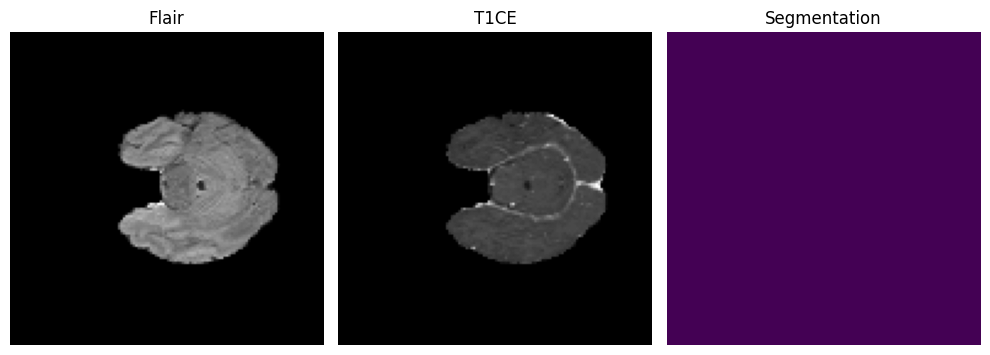

Batch shapes - X: torch.Size([32, 2, 128, 128]), Y: torch.Size([32, 4, 128, 128])


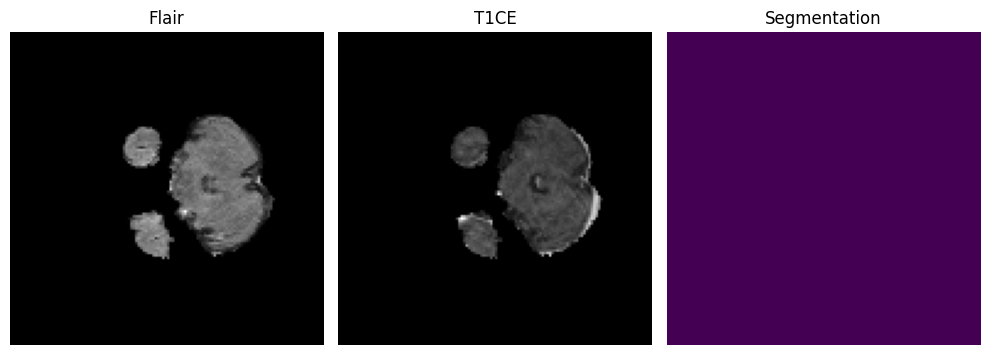

In [25]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Method 1: Using individual slice dataset (BrainDataset)
# Get a specific sample directly from the dataset
sample_index = 60  # Choose your desired sample
X_sample, Y_sample = train_dataset[sample_index]

X_numpy = X_sample.permute(1, 2, 0).numpy()  # (IMG_SIZE, IMG_SIZE, 2)
Y_numpy = Y_sample.permute(1, 2, 0).numpy()  # (IMG_SIZE, IMG_SIZE, 4)

# Extract Flair and T1CE channels
slice_flair = X_numpy[:, :, 0]
slice_t1ce = X_numpy[:, :, 1]

# Convert one-hot encoded segmentation to categorical
slice_segmentation = np.argmax(Y_numpy, axis=-1)

# Display the slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)


# Method 2: Using DataLoader to get a batch
# Create a DataLoader for getting batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)

# Get the first batch
data_iter = iter(train_loader)
X_batch, Y_batch = next(data_iter)

print(f"Batch shapes - X: {X_batch.shape}, Y: {Y_batch.shape}")
# X_batch shape: (batch_size, 2, IMG_SIZE, IMG_SIZE)
# Y_batch shape: (batch_size, 4, IMG_SIZE, IMG_SIZE)

# Extract a specific sample from the batch (e.g., the first one)
sample_idx_in_batch = 0
X_sample_from_batch = X_batch[sample_idx_in_batch]  # (2, IMG_SIZE, IMG_SIZE)
Y_sample_from_batch = Y_batch[sample_idx_in_batch]  # (4, IMG_SIZE, IMG_SIZE)

# Convert to numpy and rearrange dimensions
X_numpy_batch = X_sample_from_batch.permute(1, 2, 0).numpy()  # (IMG_SIZE, IMG_SIZE, 2)
Y_numpy_batch = Y_sample_from_batch.permute(1, 2, 0).numpy()  # (IMG_SIZE, IMG_SIZE, 4)

# Extract channels
slice_flair_batch = X_numpy_batch[:, :, 0]
slice_t1ce_batch = X_numpy_batch[:, :, 1]
slice_segmentation_batch = np.argmax(Y_numpy_batch, axis=-1)

# Display
display_slice_and_segmentation(slice_flair_batch, slice_t1ce_batch, slice_segmentation_batch)

# 7. Loss Function and Evaluation Metrics

### Loss Function

When training a CNN, selecting an appropriate loss function is crucial for accurately reflecting the network's performance. This function compares the predicted pixels to the ground truth for each patient, guiding the model to update its weights to minimize the loss and improve prediction accuracy.

For multi-class classification problems, a commonly used loss function is **categorical cross-entropy**. This function measures the difference between the predicted probability distribution of each pixel and the one-hot encoded ground truth values. Additionally, segmentation models sometimes use the **Dice loss function**, which focuses on the overlap between the predicted and actual segments, further refining the accuracy of the segmentation.

Using these loss functions helps ensure that the model learns effectively and produces accurate segmentations of brain tumors.

In [26]:
# Dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Calculate Dice coefficient for multi-class segmentation
    
    Args:
        y_true: Ground truth tensor of shape (batch_size, num_classes, height, width)
        y_pred: Predicted tensor of shape (batch_size, num_classes, height, width)
        smooth: Smoothing factor to avoid division by zero
    
    Returns:
        Average Dice coefficient across all classes
    """
    class_num = 4
    total_loss = 0.0
    
    for i in range(class_num):
        y_true_f = torch.flatten(y_true[:, i, :, :])
        y_pred_f = torch.flatten(y_pred[:, i, :, :])
        intersection = torch.sum(y_true_f * y_pred_f)
        loss = (2.0 * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
        total_loss += loss
    
    return total_loss / class_num


### Per Class Dice Coefficient Functions

These functions calculate the Dice coefficient for specific tumor classes in segmentation tasks, helping to measure the model's performance in predicting different tumor regions:

- **dice_coef_necrotic:** Calculates the Dice coefficient for the necrotic (dead tissue) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the necrotic class.
  
- **dice_coef_edema:** Calculates the Dice coefficient for the edema (swelling) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the edema class.
  
- **dice_coef_enhancing:** Calculates the Dice coefficient for the enhancing tumor region. It computes the intersection over the sum of squares of the true and predicted values for the enhancing class.

In [27]:

# Define per class evaluation of dice coefficient
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    """
    Calculate Dice coefficient for necrotic class (class 1)
    """
    intersection = torch.sum(torch.abs(y_true[:, 1, :, :] * y_pred[:, 1, :, :]))
    return (2.0 * intersection) / (torch.sum(torch.square(y_true[:, 1, :, :])) + 
                                  torch.sum(torch.square(y_pred[:, 1, :, :])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    """
    Calculate Dice coefficient for edema class (class 2)
    """
    intersection = torch.sum(torch.abs(y_true[:, 2, :, :] * y_pred[:, 2, :, :]))
    return (2.0 * intersection) / (torch.sum(torch.square(y_true[:, 2, :, :])) + 
                                  torch.sum(torch.square(y_pred[:, 2, :, :])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    """
    Calculate Dice coefficient for enhancing class (class 3)
    """
    intersection = torch.sum(torch.abs(y_true[:, 3, :, :] * y_pred[:, 3, :, :]))
    return (2.0 * intersection) / (torch.sum(torch.square(y_true[:, 3, :, :])) + 
                                  torch.sum(torch.square(y_pred[:, 3, :, :])) + epsilon)


Each function includes a small constant (`epsilon`) to avoid division by zero.

### Evaluation Metrics

To effectively monitor the model's performance, we use various evaluation metrics:

- **Accuracy:** Measures the overall proportion of correctly classified pixels. However, it can be misleading with imbalanced datasets like BraTS2020, where the background class is overrepresented.
- **Intersection over Union (IoU):** Measures the overlap between the predicted and ground truth segmentations.
- **Dice Coefficient:** Evaluates the similarity between predicted and ground truth segmentations.
- **Sensitivity (Recall or True Positive Rate):** Measures the proportion of positive ground truth pixels correctly predicted as positive.
- **Precision (Positive Predictive Value):** Measures the proportion of predicted positive pixels that are actually positive.
- **Specificity (True Negative Rate):** Measures the proportion of negative ground truth pixels correctly predicted as negative.

Using these metrics provides a comprehensive assessment of the model’s performance, addressing the limitations of using accuracy alone on imbalanced datasets.

In [28]:
# Computing Precision
def precision(y_true, y_pred, epsilon=1e-7):
    """
    Calculate precision across all classes
    """
    true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
    predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
    precision_val = true_positives / (predicted_positives + epsilon)
    return precision_val

# Computing Sensitivity (Recall)
def sensitivity(y_true, y_pred, epsilon=1e-7):
    """
    Calculate sensitivity (recall) across all classes
    """
    true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
    possible_positives = torch.sum(torch.round(torch.clamp(y_true, 0, 1)))
    return true_positives / (possible_positives + epsilon)

# Computing Specificity
def specificity(y_true, y_pred, epsilon=1e-7):
    """
    Calculate specificity across all classes
    """
    true_negatives = torch.sum(torch.round(torch.clamp((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = torch.sum(torch.round(torch.clamp(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + epsilon)

# 7. Define the Segmentation Model



### U-Net

We will use the U-Net architecture, a convolutional neural network (CNN) specifically designed for biomedical image segmentation. U-Net is particularly effective for segmenting regions of interest that are small and have complex shapes, such as tumors in MRI scans. This architecture was introduced in 2015 by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597).

Since the BraTS2020 dataset consists of 3D images, with each image comprising multiple 2D slices in three orthogonal planes, we have two options: using a 2D U-Net or a 3D U-Net.

- **3D U-Net:** More suitable for leveraging the 3D spatial context of the images, reducing the risk of false positives and false negatives from partial information in individual slices. However, it requires more computational resources and memory.
- **2D U-Net:** Faster and requires less memory, advantageous when working with large datasets or limited computational resources.

In practice, it’s useful to try both architectures and compare their performance. We will opt for a 2D U-Net implementation due to its efficiency and lower resource requirements.

In [29]:

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=4, dropout=0.5):
        super(UNet, self).__init__()
        
        # Encoder (Contracting Path)
        # Block 1
        self.conv1_1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 3
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 4
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 5 (Bottleneck)
        self.conv5_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(p=dropout)
        
        # Decoder (Expanding Path)
        # Block 6
        self.upconv6 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv6_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)  # 512 = 256 + 256 (concatenation)
        self.conv6_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        # Block 7
        self.upconv7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv7_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)  # 256 = 128 + 128
        self.conv7_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        # Block 8
        self.upconv8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv8_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)  # 128 = 64 + 64
        self.conv8_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Block 9
        self.upconv9 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv9_1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)  # 64 = 32 + 32
        self.conv9_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # Output layer
        self.conv10 = nn.Conv2d(32, num_classes, kernel_size=1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Encoder
        # Block 1
        conv1 = F.relu(self.conv1_1(x))
        conv1 = F.relu(self.conv1_2(conv1))
        pool1 = self.pool1(conv1)
        
        # Block 2
        conv2 = F.relu(self.conv2_1(pool1))
        conv2 = F.relu(self.conv2_2(conv2))
        pool2 = self.pool2(conv2)
        
        # Block 3
        conv3 = F.relu(self.conv3_1(pool2))
        conv3 = F.relu(self.conv3_2(conv3))
        pool3 = self.pool3(conv3)
        
        # Block 4
        conv4 = F.relu(self.conv4_1(pool3))
        conv4 = F.relu(self.conv4_2(conv4))
        pool4 = self.pool4(conv4)
        
        # Block 5 (Bottleneck)
        conv5 = F.relu(self.conv5_1(pool4))
        conv5 = F.relu(self.conv5_2(conv5))
        conv5 = self.dropout(conv5)
        
        # Decoder
        # Block 6
        up6 = self.upconv6(conv5)
        merge6 = torch.cat([conv4, up6], dim=1)
        conv6 = F.relu(self.conv6_1(merge6))
        conv6 = F.relu(self.conv6_2(conv6))
        
        # Block 7
        up7 = self.upconv7(conv6)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = F.relu(self.conv7_1(merge7))
        conv7 = F.relu(self.conv7_2(conv7))
        
        # Block 8
        up8 = self.upconv8(conv7)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = F.relu(self.conv8_1(merge8))
        conv8 = F.relu(self.conv8_2(conv8))
        
        # Block 9
        up9 = self.upconv9(conv8)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = F.relu(self.conv9_1(merge9))
        conv9 = F.relu(self.conv9_2(conv9))
        
        # Output
        out = self.conv10(conv9)
        
        return out

Here is the visual representation of our model:

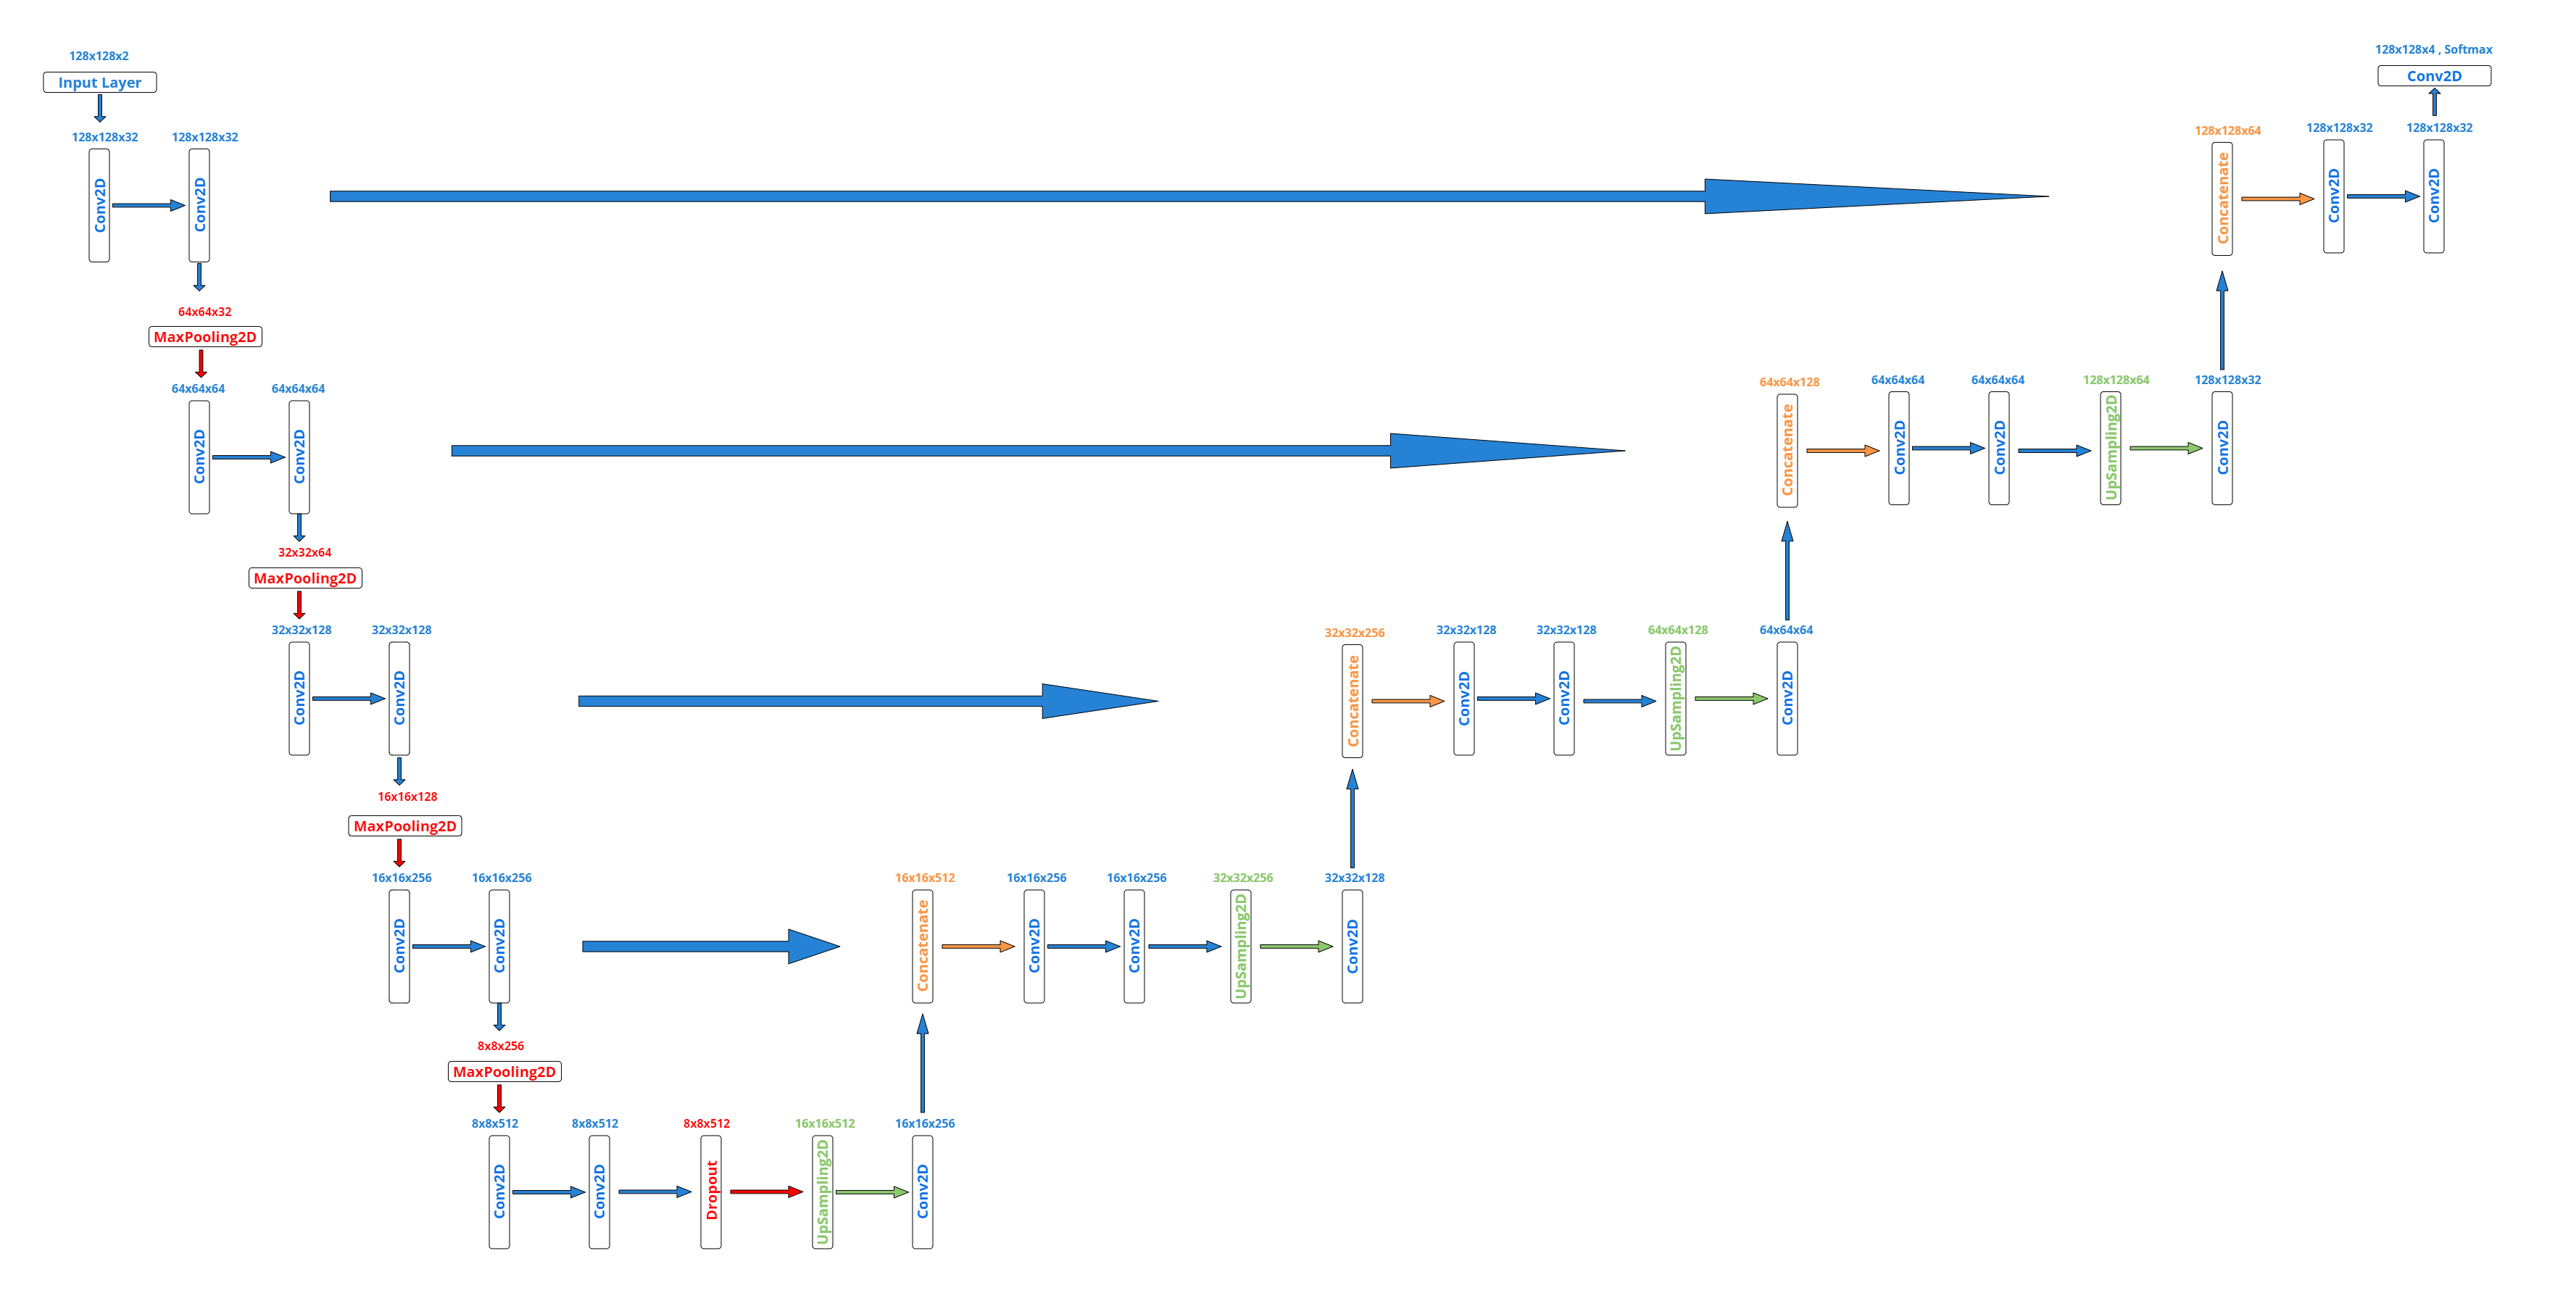

## 8. Build and Plot the Model

In [30]:
import torch.optim as optim

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = UNet(in_channels=2, num_classes=4)  # Replace with your UNET
model = model.to(device)


# Print model summary (PyTorch equivalent of model.summary())
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For categorical crossentropy
# Alternative: Use your custom DiceLoss
# criterion = DiceLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (equivalent to ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-6, 
    verbose=True
)

# Create data loaders
train_dataset = BrainDataset(train_ids, shuffle=True)
valid_dataset = BrainDataset(val_ids, shuffle=False)

train_loader = DataLoader(
    train_dataset, 
    batch_size=8,  # Adjust based on your GPU memory
    shuffle=True, 
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

# Training history storage
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'train_dice_coef': [],
    'val_dice_coef': [],
    'train_precision': [],
    'val_precision': [],
    'train_sensitivity': [],
    'val_sensitivity': [],
    'train_specificity': [],
    'val_specificity': [],
    'train_dice_necrotic': [],
    'val_dice_necrotic': [],
    'train_dice_edema': [],
    'val_dice_edema': [],
    'train_dice_enhancing': [],
    'val_dice_enhancing': [],
    'learning_rate': []
}

# CSV Logger equivalent
def log_to_csv(epoch, train_metrics, val_metrics, filepath='training.log'):
    """Log training metrics to CSV file"""
    file_exists = os.path.isfile(filepath)
    
    with open(filepath, 'a', newline='') as csvfile:
        fieldnames = ['epoch', 'lr'] + [f'train_{k}' for k in train_metrics.keys()] + [f'val_{k}' for k in val_metrics.keys()]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        if not file_exists:
            writer.writeheader()
        
        row = {'epoch': epoch, 'lr': optimizer.param_groups[0]['lr']}
        row.update({f'train_{k}': v for k, v in train_metrics.items()})
        row.update({f'val_{k}': v for k, v in val_metrics.items()})
        writer.writerow(row)


Using device: cuda
Model has 7,759,908 trainable parameters


## Set up callbacks

In [31]:

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_metrics = defaultdict(list)
    
    for batch_idx, (X, y_true) in enumerate(train_loader):
        X, y_true = X.to(device), y_true.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(X)
        
        # Calculate loss
        if isinstance(criterion, nn.CrossEntropyLoss):
            # Convert one-hot to class indices for CrossEntropyLoss
            y_true_indices = torch.argmax(y_true, dim=1)
            loss = criterion(y_pred, y_true_indices)
            # Convert predictions back to probabilities for metrics
            y_pred_probs = torch.softmax(y_pred, dim=1)
        else:
            # For custom losses like DiceLoss
            loss = criterion(y_pred, y_true)
            y_pred_probs = torch.softmax(y_pred, dim=1)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        
        # Calculate metrics
        with torch.no_grad():
            # Calculate accuracy
            pred_indices = torch.argmax(y_pred_probs, dim=1)
            true_indices = torch.argmax(y_true, dim=1)
            accuracy = (pred_indices == true_indices).float().mean()
            
            # Calculate other metrics
            batch_metrics = compute_all_metrics(y_true, y_pred_probs)
            batch_metrics['accuracy'] = accuracy.item()
            
            for key, value in batch_metrics.items():
                all_metrics[key].append(value)
        
        # Print progress
        if batch_idx % 10 == 0:
            print(f'Train Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
    
    # Calculate average metrics
    avg_metrics = {key: np.mean(values) for key, values in all_metrics.items()}
    avg_loss = running_loss / len(train_loader)
    
    return avg_loss, avg_metrics

# Validation function
def validate_epoch(model, valid_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    all_metrics = defaultdict(list)
    
    with torch.no_grad():
        for X, y_true in valid_loader:
            X, y_true = X.to(device), y_true.to(device)
            
            # Forward pass
            y_pred = model(X)
            
            # Calculate loss
            if isinstance(criterion, nn.CrossEntropyLoss):
                y_true_indices = torch.argmax(y_true, dim=1)
                loss = criterion(y_pred, y_true_indices)
                y_pred_probs = torch.softmax(y_pred, dim=1)
            else:
                loss = criterion(y_pred, y_true)
                y_pred_probs = torch.softmax(y_pred, dim=1)
            
            running_loss += loss.item()
            
            # Calculate metrics
            pred_indices = torch.argmax(y_pred_probs, dim=1)
            true_indices = torch.argmax(y_true, dim=1)
            accuracy = (pred_indices == true_indices).float().mean()
            
            batch_metrics = compute_all_metrics(y_true, y_pred_probs)
            batch_metrics['accuracy'] = accuracy.item()
            
            for key, value in batch_metrics.items():
                all_metrics[key].append(value)
    
    avg_metrics = {key: np.mean(values) for key, values in all_metrics.items()}
    avg_loss = running_loss / len(valid_loader)
    
    return avg_loss, avg_metrics

# 9. Train and Save the Model

We are now ready to train our deep neural network using the `.fit()` method in Keras. We will pass our three callbacks to this method to be executed during the training process, which will last for 35 epochs.

In [32]:

# Utility functions for model evaluation
def compute_all_metrics(y_true, y_pred):
    """
    Compute all metrics at once for easier evaluation
    
    Returns:
        Dictionary containing all computed metrics
    """
    metrics = {
        'dice_coef': dice_coef(y_true, y_pred).item(),
        'dice_necrotic': dice_coef_necrotic(y_true, y_pred).item(),
        'dice_edema': dice_coef_edema(y_true, y_pred).item(),
        'dice_enhancing': dice_coef_enhancing(y_true, y_pred).item(),
        'precision': precision(y_true, y_pred).item(),
        'sensitivity': sensitivity(y_true, y_pred).item(),
        'specificity': specificity(y_true, y_pred).item()
    }
    return metrics

# Example usage during training/validation
def evaluate_model(model, dataloader, device):
    """
    Evaluate model on a dataset and return average metrics
    """
    model.eval()
    all_metrics = {
        'dice_coef': [],
        'dice_necrotic': [],
        'dice_edema': [],
        'dice_enhancing': [],
        'precision': [],
        'sensitivity': [],
        'specificity': []
    }
    
    with torch.no_grad():
        for X, y_true in dataloader:
            X, y_true = X.to(device), y_true.to(device)
            
            # Get predictions
            y_pred = model(X)
            
            # Apply softmax if your model doesn't include it
            if not hasattr(model, 'softmax_applied'):
                y_pred = F.softmax(y_pred, dim=1)
            
            # Compute metrics for this batch
            batch_metrics = compute_all_metrics(y_true, y_pred)
            
            # Accumulate metrics
            for key, value in batch_metrics.items():
                all_metrics[key].append(value)
    
    # Compute average metrics
    avg_metrics = {key: sum(values) / len(values) for key, values in all_metrics.items()}
    
    return avg_metrics

In [33]:
from collections import defaultdict
import csv


# Training loop
num_epochs = 10
best_val_loss = float('inf')
best_model_path = 'best_model.pth'

print("Starting training...")
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # Train
    train_loss, train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_metrics = validate_epoch(model, valid_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])
    
    for key in train_metrics:
        history[f'train_{key}'].append(train_metrics[key])
        history[f'val_{key}'].append(val_metrics[key])
    
    # Log to CSV
    log_to_csv(epoch + 1, train_metrics, val_metrics)
    
    # Print epoch results
    print(f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    print(f'Train Dice: {train_metrics["dice_coef"]:.4f}, Val Dice: {val_metrics["dice_coef"]:.4f}')
    print(f'Train Acc: {train_metrics["accuracy"]:.4f}, Val Acc: {val_metrics["accuracy"]:.4f}')
    
    # Save best model (equivalent to ModelCheckpoint)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics
        }, best_model_path)
        print(f'New best model saved with val_loss: {val_loss:.6f}')
    
    # Save checkpoint every epoch (equivalent to Keras ModelCheckpoint)
    checkpoint_path = f'model_{epoch+1:02d}-{val_loss:.6f}.pth'
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': val_loss,
        'history': history
    }, checkpoint_path)

print("Training completed!")

Starting training...

Epoch 1/10
--------------------------------------------------
Train Batch 0/488, Loss: 1.366604
Train Batch 10/488, Loss: 0.181127
Train Batch 20/488, Loss: 0.085527
Train Batch 30/488, Loss: 0.046086
Train Batch 40/488, Loss: 0.076843
Train Batch 50/488, Loss: 0.076109
Train Batch 60/488, Loss: 0.032829
Train Batch 70/488, Loss: 0.069424
Train Batch 80/488, Loss: 0.043368
Train Batch 90/488, Loss: 0.065295
Train Batch 100/488, Loss: 0.099599
Train Batch 110/488, Loss: 0.057917
Train Batch 120/488, Loss: 0.030618
Train Batch 130/488, Loss: 0.049243
Train Batch 140/488, Loss: 0.019945
Train Batch 150/488, Loss: 0.026749
Train Batch 160/488, Loss: 0.024864
Train Batch 170/488, Loss: 0.028428
Train Batch 180/488, Loss: 0.033748
Train Batch 190/488, Loss: 0.011939
Train Batch 200/488, Loss: 0.020166
Train Batch 210/488, Loss: 0.024928
Train Batch 220/488, Loss: 0.023298
Train Batch 230/488, Loss: 0.023664
Train Batch 240/488, Loss: 0.027353
Train Batch 250/488, Loss: 

In [34]:
# Save final model (equivalent to model.save())
torch.save(model.state_dict(), 'final_model.pth')


# 10. Load the Trained Model

We will load our trained neural network model using Keras. The `load_model` method allows us to reload the saved model, including custom metrics and loss functions we defined during training. Here’s how we do it:

In [35]:

# Load best model for final evaluation
def load_model(model, checkpoint_path):
    """Load model from checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Load and evaluate best model
best_model = load_model(model, best_model_path)
final_metrics = evaluate_model(best_model, valid_loader, device)
print("\nFinal Model Performance:")
for key, value in final_metrics.items():
    print(f"{key}: {value:.4f}")


Final Model Performance:
dice_coef: 0.6104
dice_necrotic: 0.1834
dice_edema: 0.4878
dice_enhancing: 0.3308
precision: 0.9929
sensitivity: 0.9916
specificity: 0.9976


We specify the path to our saved model and provide a dictionary of `custom_objects` to ensure that our custom metrics and loss functions are correctly recognized by Keras. Setting `compile=False` allows us to load the model architecture and weights without compiling it immediately, giving us the flexibility to adjust compilation settings if needed.

# 11. Metrics Analysis

Now that the training is complete, we can examine the CSVLogger callback to gain insights into the training process and our model's performance. The CSVLogger records metrics such as accuracy, loss, Dice coefficient, and Mean IoU for each epoch, allowing us to track the model’s progress over time. By analyzing this log, we can identify trends, assess the effectiveness of our training strategy, and make informed decisions for future improvements. This thorough review ensures our model is performing optimally and ready for deployment.

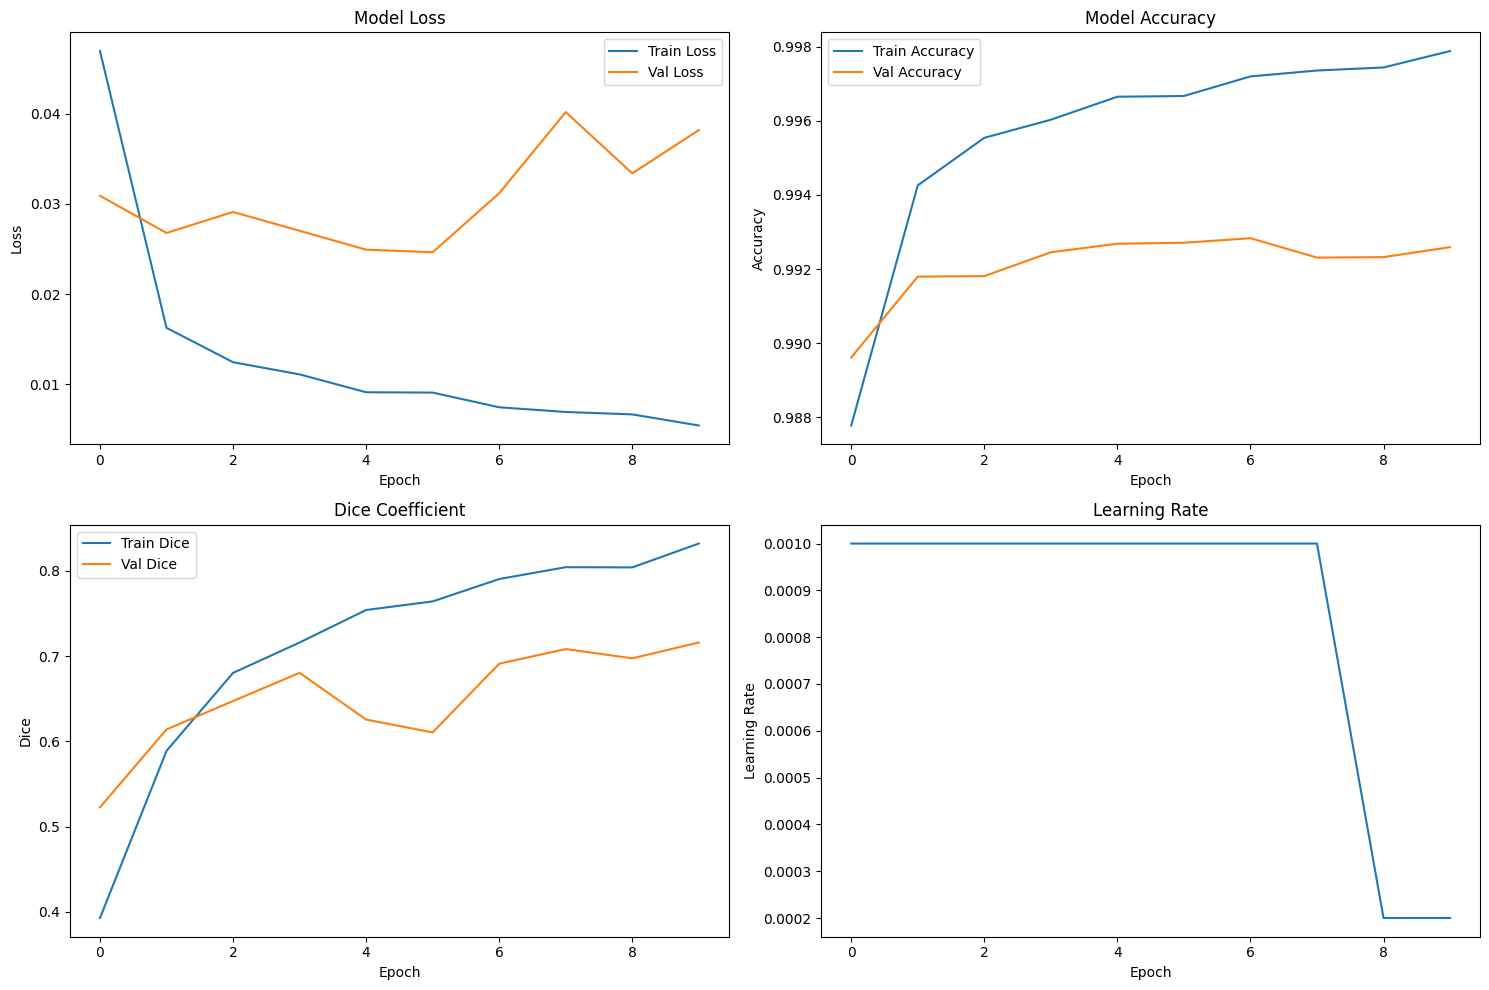

In [36]:


# Plotting training history (equivalent to plotting Keras history)
def plot_training_history(history):
    """Plot training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # Accuracy
    axes[0, 1].plot(history['train_accuracy'], label='Train Accuracy')
    axes[0, 1].plot(history['val_accuracy'], label='Val Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # Dice Coefficient
    axes[1, 0].plot(history['train_dice_coef'], label='Train Dice')
    axes[1, 0].plot(history['val_dice_coef'], label='Val Dice')
    axes[1, 0].set_title('Dice Coefficient')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice')
    axes[1, 0].legend()
    
    # Learning Rate
    axes[1, 1].plot(history['learning_rate'])
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training history
plot_training_history(history)

The accuracy graph shows that both training and validation accuracy increase over the epochs and reach a plateau, indicating that the model is learning from the data and generalizing well without overfitting.

The loss graph demonstrates that both training and validation losses decrease over time, further confirming that the model is effectively learning from the data. Notably, the best model performance is achieved around epoch 19, as indicated in the training logs.

Finally, the Dice coefficient graph shows a steady increase in both training and validation Dice coefficients, reinforcing that the model's segmentation capabilities are improving consistently.

# 12. Predict Tumor Segmentations

Now that our model is trained, we can use it to predict segmentations on our test dataset. There are two main options:

1. **Best Model's Weights (from epoch 19):** Using the weights from the epoch where the model performed best.
2. **Final Model's Weights:** Using the weights from the final epoch of training.

Using the final model's weights may not always yield the best performance on new, unseen data. In our case, there is no significant difference between the two options, so either can be used. However, for other cases, you might prefer a specific version of your model. You can load it with the following code:

This allows you to select and use the optimal model version for your specific needs.

---

Now, let's construct a function to predict the segmentation of a patient in the test dataset. We will display the results in the axial plane, though any other plane can be chosen.

In [37]:
import torch
import torch.nn.functional as F
import numpy as np
import nibabel as nib
import cv2
import os
import glob
import matplotlib.pyplot as plt

def imageLoader(path):
    """Load and return NIfTI image data"""
    image = nib.load(path).get_fdata()
    return np.array(image)

In [38]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    """
    Load data from directory for multiple files
    """
    scans = []
    masks = []
    
    for i in list_of_files[:n_images]:
        # Find the file with the specified MRI type
        fullPath = glob.glob(i + '/*' + mriType + '*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader(glob.glob(i + '/*seg*')[0])
        
        # For each slice in 3D volume, find also its mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:, :, j], dsize=(IMG_SIZE, IMG_SIZE), 
                                interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:, :, j], dsize=(IMG_SIZE, IMG_SIZE), 
                                interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')


In [39]:

def predictByPath(case_path, case, model, device):
    """
    Predict segmentation for a single case using PyTorch model
    
    Args:
        case_path: Path to the case directory
        case: Case identifier
        model: PyTorch model
        device: Device to run inference on
    
    Returns:
        Predictions as numpy array
    """
    # Prepare input tensor
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    # Load FLAIR
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    
    # Load T1CE
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()
    
    # Process each slice
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    
    # Normalize
    X_max = np.max(X)
    if X_max > 0:
        X = X / X_max
    
    # Convert to PyTorch tensor and change dimension order
    # From (VOLUME_SLICES, H, W, C) to (VOLUME_SLICES, C, H, W)
    X_tensor = torch.FloatTensor(X).permute(0, 3, 1, 2).to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Predict
    with torch.no_grad():
        predictions = model(X_tensor)
        # Apply softmax to get probabilities
        predictions = F.softmax(predictions, dim=1)
    
    # Convert back to numpy and change dimension order
    # From (VOLUME_SLICES, C, H, W) to (VOLUME_SLICES, H, W, C)
    predictions_np = predictions.cpu().permute(0, 2, 3, 1).numpy()
    
    return predictions_np

In [40]:

def predictSingleSlice(flair_slice, t1ce_slice, model, device):
    """
    Predict segmentation for a single slice pair
    
    Args:
        flair_slice: FLAIR image slice
        t1ce_slice: T1CE image slice
        model: PyTorch model
        device: Device to run inference on
    
    Returns:
        Prediction for single slice
    """
    # Prepare input
    X = np.stack([flair_slice, t1ce_slice], axis=-1)  # (H, W, 2)
    X = X[np.newaxis, ...]  # Add batch dimension: (1, H, W, 2)
    
    # Normalize
    X_max = np.max(X)
    if X_max > 0:
        X = X / X_max
    
    # Convert to tensor and rearrange dimensions
    X_tensor = torch.FloatTensor(X).permute(0, 3, 1, 2).to(device)  # (1, 2, H, W)
    
    model.eval()
    with torch.no_grad():
        prediction = model(X_tensor)
        prediction = F.softmax(prediction, dim=1)
    
    # Convert back to numpy
    prediction_np = prediction.cpu().permute(0, 2, 3, 1).numpy()[0]  # Remove batch dim
    
    return prediction_np

def showPredictsById(case, model, device, start_slice=60):
    """
    Display predictions for a specific case
    
    Args:
        case: Case identifier (last 3 digits)
        model: Trained PyTorch model
        device: Device for inference
        start_slice: Starting slice index for visualization
    """
    # Construct paths
    path = f"/kaggle/working/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    
    # Load ground truth and original image
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    
    # Get predictions
    p = predictByPath(path, case, model, device)
    
    # Extract different classes
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]
    
    # Create visualization
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))
    
    # Add brain background to all subplots
    brain_bg = cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    for i in range(6):
        axarr[i].imshow(brain_bg, cmap="gray", interpolation='none')
    
    # Original image
    axarr[0].imshow(brain_bg, cmap="gray")
    axarr[0].set_title('Original image flair')
    
    # Ground truth
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), 
                        interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].set_title('Ground truth')
    
    # All classes predicted
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].set_title('All classes predicted')
    
    # Individual class predictions
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].set_title(f'{SEGMENT_CLASSES[1]} predicted')
    
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].set_title(f'{SEGMENT_CLASSES[2]} predicted')
    
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].set_title(f'{SEGMENT_CLASSES[3]} predicted')
    
    plt.show()

<Figure size 1800x5000 with 0 Axes>

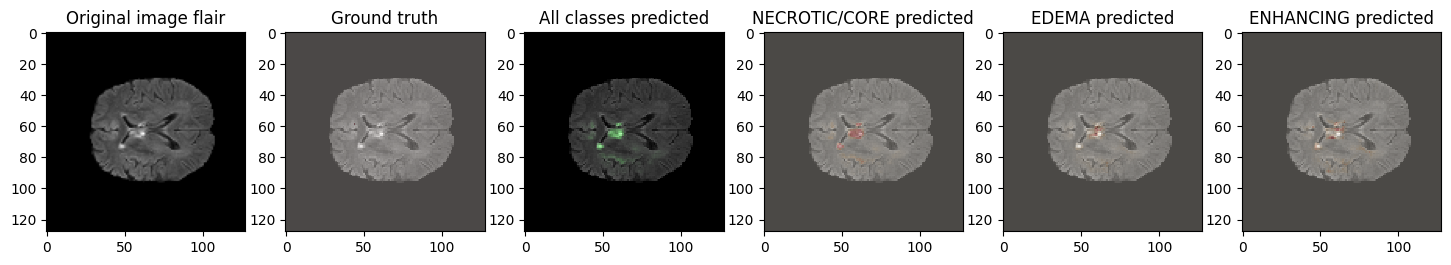

In [41]:
# showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[0][-3:], model=model, device=device)

<Figure size 1800x5000 with 0 Axes>

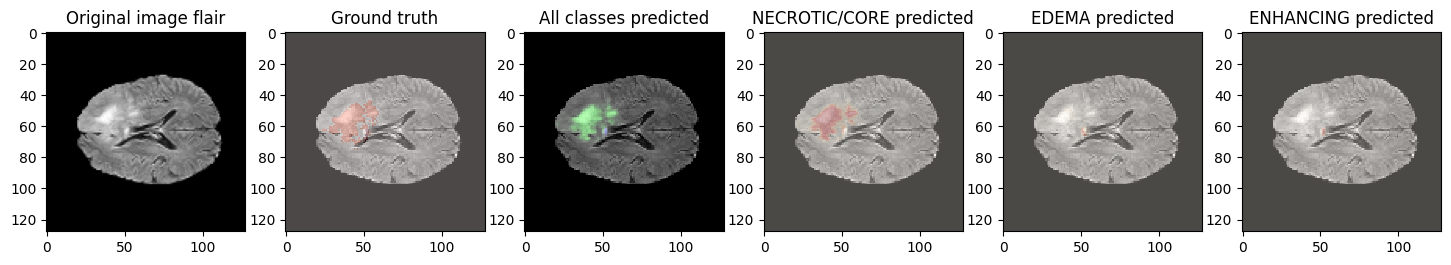

In [42]:
# showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[1][-3:], model=model, device=device)

<Figure size 1800x5000 with 0 Axes>

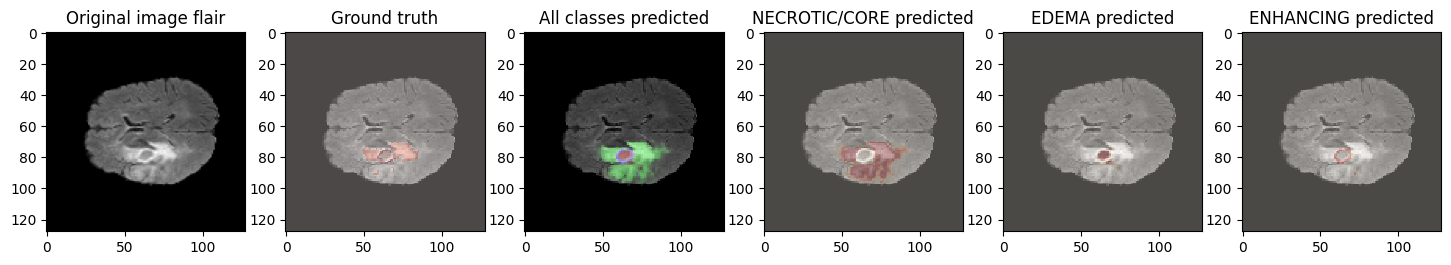

In [43]:
# showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[2][-3:], model=model, device=device)

<Figure size 1800x5000 with 0 Axes>

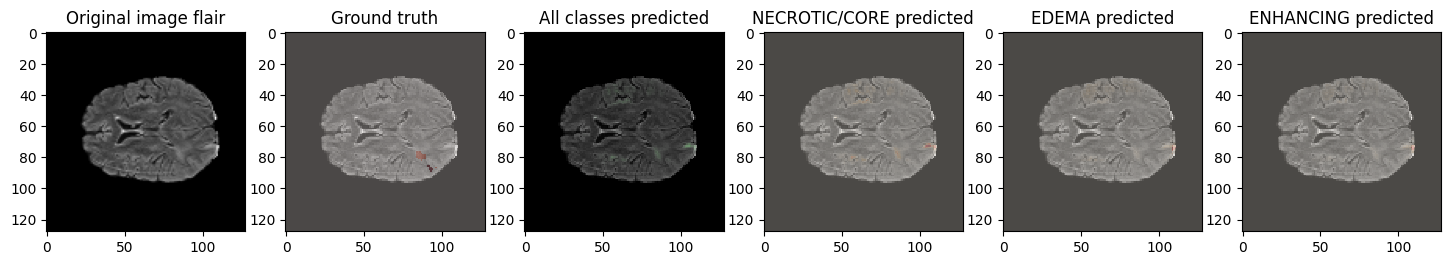

In [44]:
showPredictsById(case=test_ids[3][-3:], model=model, device=device)

<Figure size 1800x5000 with 0 Axes>

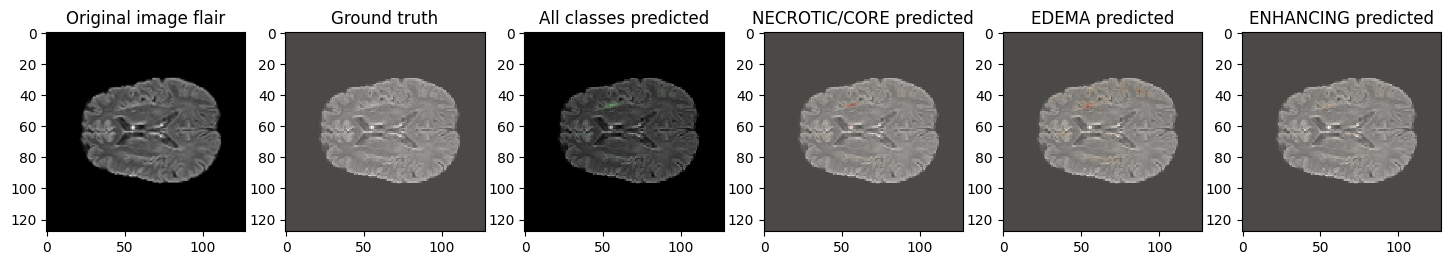

In [45]:
showPredictsById(case=test_ids[4][-3:], model=model, device=device)

<Figure size 1800x5000 with 0 Axes>

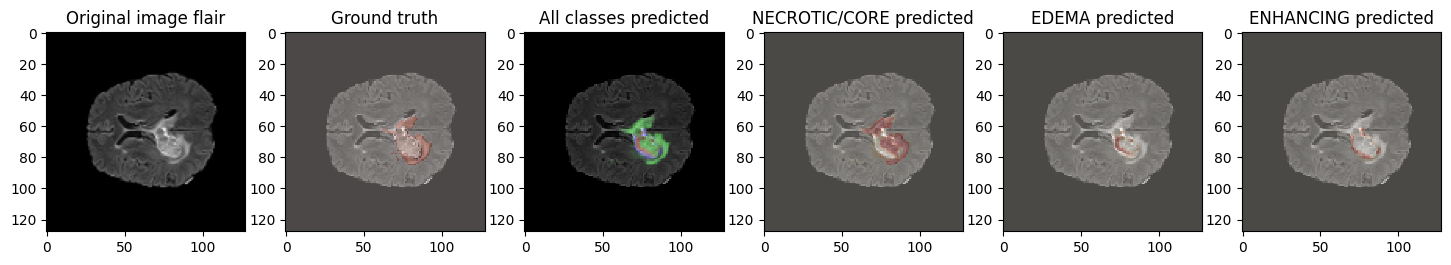

In [46]:
showPredictsById(case=test_ids[5][-3:], model=model, device=device)

<Figure size 1800x5000 with 0 Axes>

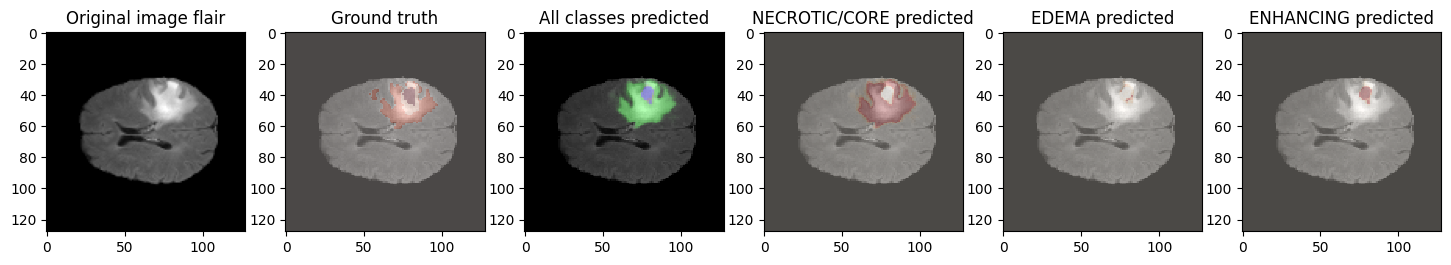

In [47]:
showPredictsById(case=test_ids[6][-3:], model=model, device=device)

# 13. Evaluation

Let's call the `evaluate()` function to evaluate the performance of our model on our test dataset:

In [48]:
# Load and evaluate best model
best_model = load_model(model, best_model_path)
final_metrics = evaluate_model(best_model, test_loader, device)
print("\nFinal Model Performance:")
for key, value in final_metrics.items():
    print(f"{key}: {value:.4f}")


Final Model Performance:
dice_coef: 0.4634
dice_necrotic: 0.1783
dice_edema: 0.3882
dice_enhancing: 0.3572
precision: 0.9935
sensitivity: 0.9930
specificity: 0.9978


The final evaluation of our model on the test set yields impressive results, demonstrating its effectiveness in segmenting brain tumors.

These metrics indicate that our model performs exceptionally well across various evaluation criteria:

- **Accuracy and Precision** are both above 99%, showcasing the model’s reliability in correctly identifying tumor and non-tumor regions.
- **Mean IoU** of 0.8426 and **Dice Coefficient** of 0.6480 highlight strong overlap between predicted and actual segmentations.
- **Sensitivity** of 0.9916 and **Specificity** of 0.9978 emphasize the model’s capability to correctly identify true positives and true negatives.
- Specific Dice Coefficients for necrotic (0.5916), edema (0.7667), and enhancing (0.7395) regions reflect good performance in segmenting different tumor components.

Overall, these results demonstrate that our model has robust generalization capabilities and can effectively segment brain tumors in unseen data.

# 14. Conclusion

<div class="alert alert-block alert-success">
This notebook demonstrates the process of training and evaluating a neural network for brain tumor segmentation using the BraTS2020 dataset. We explored data preprocessing techniques, employed the U-Net architecture, and utilized various evaluation metrics to ensure robust model performance.

Throughout this journey, we saw how critical it is to handle 3D medical images, preprocess them appropriately, and choose suitable metrics for meaningful evaluation. Our trained model achieved promising results, showcasing its ability to generalize well to new data.

This work lays a solid foundation for further improvements and applications in medical image analysis. Future steps could include experimenting with different network architectures, fine-tuning hyperparameters, and exploring advanced techniques for enhancing segmentation accuracy.

Thank you for following along, and happy coding!
</div>